In [45]:
import pandas as pd
import numpy as np

In [60]:
df = pd.read_csv(r"C:\Users\Aron\Desktop\ml-zoomcamp\03-classification\data\bank-full.csv", delimiter = ";" )

In [47]:
features=['age', 'job', 'marital', 'education', 'balance', 'housing',
'contact', 'day', 'month', 'duration', 'campaign', 'pdays','previous', 'poutcome', 'y']

df = df[features]

In [48]:
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

df['y'] = df['y'].map({'yes': 1, 'no': 0})


In [49]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [50]:
df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

In [51]:
y_train=df_train.y.values
y_val=df_val.y.values
y_test=df_test.y.values

In [58]:
del df_train['y']
del df_val['y']
del df_test['y']

**Question 1**

In [62]:
from sklearn.metrics import roc_auc_score

variables = ['balance', 'day', 'duration', 'previous']
highest_auc = 0
best_variable = None

for var in variables:
    auc = roc_auc_score(y_train, df_train[var])  
    if auc < 0.5:
        auc = roc_auc_score(y_train,-df_train[var])  
    
    print(f"AUC of {var}: {auc}")
    
    if auc > highest_auc:
        highest_auc = auc
        best_variable = var

print(f"Variable with highest AUC: {best_variable}, AUC: {highest_auc}")

AUC of balance: 0.5888313805382317
AUC of day: 0.525957882383908
AUC of duration: 0.8147002759670778
AUC of previous: 0.5985653242764153
Variable with highest AUC: duration, AUC: 0.8147002759670778


**Question 2**

In [63]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(df_train.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

X_val = dv.transform(df_val.to_dict(orient='records'))

y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)
print(f"AUC on validation set: {round(auc, 3)}")

AUC on validation set: 0.901


**Question 3**

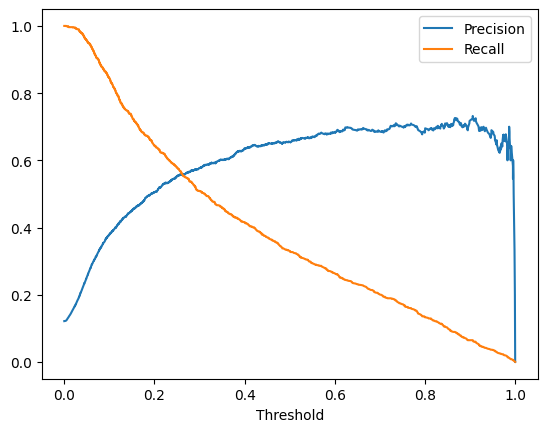

Threshold where precision and recall intersect: 0.2625512492953845


In [64]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val).ravel()  

precisions, recalls, thresholds = precision_recall_curve(y_val_bin, y_pred)

plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.show()

intersect_threshold = thresholds[np.argmin(np.abs(precisions - recalls))]
print(f"Threshold where precision and recall intersect: {intersect_threshold}")

**Question 4**

In [65]:
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

max_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[max_f1_index]
print(f"Threshold where F1 is maximal: {best_threshold}")

Threshold where F1 is maximal: 0.9998578973431539


C:\Users\Aron\AppData\Local\Temp\ipykernel_1964\1897186258.py:1: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precisions * recalls) / (precisions + recalls)


**Question 5**

In [66]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_full_train = df_full_train.drop(columns=['y'])  
y_full_train = df_full_train['y']  

kf = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_index, val_index in kf.split(X_full_train):
    X_train, X_val = X_full_train.iloc[train_index], X_full_train.iloc[val_index]
    y_train, y_val = y_full_train.iloc[train_index], y_full_train.iloc[val_index]
    
    dv = DictVectorizer(sparse=False)
    X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
    X_val_enc = dv.transform(X_val.to_dict(orient='records'))
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_enc, y_train)
    y_pred = model.predict_proba(X_val_enc)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

print(f"Standard deviation of scores: {np.std(scores)}")

Standard deviation of scores: 0.005691215739889739


**Question 6**

In [67]:
C_values = [0.000001, 0.001, 1]
results = {}

for C in C_values:
    scores = []
    for train_index, val_index in kf.split(df_full_train):
        X_train, X_val = df_full_train.iloc[train_index], df_full_train.iloc[val_index]
        y_train, y_val = y_full_train.iloc[train_index], y_full_train.iloc[val_index]
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(dv.fit_transform(X_train.to_dict(orient='records')), y_train)
        y_pred = model.predict_proba(dv.transform(X_val.to_dict(orient='records')))[:, 1]
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results[C] = (mean_score, std_score)

best_C = min(results, key=lambda x: (-results[x][0], results[x][1]))
print(f"Best C value: {best_C}")

Best C value: 1
